In [58]:
cash0 = 100000
#lambda = 10

using JuMP, Cbc, NamedArrays, CSV

raw1 = CSV.read("AMZN.csv")

days = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

values = raw1[:,2]

function solveOpt(lambda)
    m = Model(solver=CbcSolver())

    @variable(m, sell[days] >= 0, Int)
    @variable(m, buy[days] >= 0, Int)
    @variable(m, hold[days] >= 0, Int)
    @variable(m, cash[days] >= 0)
    @variable(m, sellCount[days], Bin)
    @variable(m, buyCount[days], Bin)

    tradeCount = 0

    for i in days
            if i == 1
                @constraint(m, cash[1] == cash0 - (values[1]*buy[1]))
                @constraint(m, hold[1] == buy[1])
                @constraint(m, sell[1] == 0)
            else
                @constraint(m, hold[i] <= hold[i-1] + buy[i] - sell[i])
                @constraint(m, sell[i] <= hold[i-1])
                @constraint(m, cash[i] == cash[i-1] + (values[i]*sell[i]) - (values[i]*buy[i]))
            end
    end

    for i in days
        @constraint(m, sell[i] <= sellCount[i]*100)
        @constraint(m, buy[i] <= buyCount[i]*100)
    end


    @objective(m, Max, cash[21] - lambda*(sum(sellCount) + sum(buyCount)))
    solve(m)

    returnVal = getobjectivevalue(m)
    sellVal = getvalue(sell)
    buyVal = getvalue(buy)
    holdVal = getvalue(hold)
    
    
    tradeCount = getvalue(sum(sellCount))+getvalue(sum(buyCount))
    
    #cash at end of 21 days
    J1 = getvalue(cash[21])
    
    #total number of trades in 21 days
    J2 = getvalue(sum(sellCount))+getvalue(sum(buyCount))
    return (J1, J2, returnVal)
end
;


#tradeCount = getvalue(sum(sellCount))+getvalue(sum(buyCount))
#println("Cash at end of month ", returnVal)
#println("Total trades made: ", tradeCount)
#println("Stock sell values", sellVal)
#println("Stock buy values", buyVal)
#println("Stock hold values", holdVal)


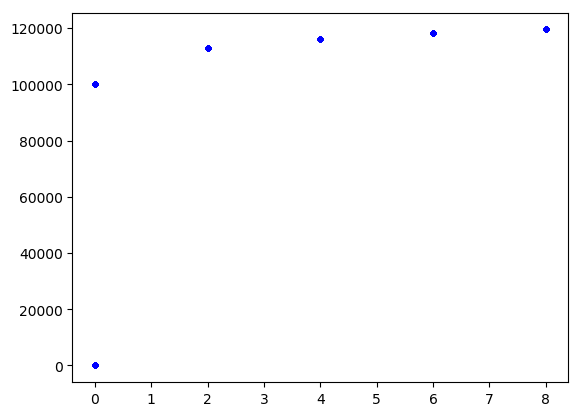

In [67]:
Npts = 30
J1 = zeros(Npts)
J2 = zeros(Npts)

using PyPlot
for (i,λ) in enumerate(range(100,10000,length=Npts))
    (J1[i],J2[i],uu) = solveOpt(λ)
    plot(J2, J1, "b.")
end;


    